In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from chronos import ChronosPipeline
from nixtlats import NixtlaClient
from neuralforecast.models import MLP, NBEATS
from neuralforecast.losses.pytorch import HuberLoss
from neuralforecast.core import NeuralForecast
from IPython.display import clear_output
from tqdm import tqdm
import pickle
import sys
import os

In [11]:
# Add the 'src/utils' directory to the module search path
sys.path.append('../src')

from utils.nexutil import *  # Module from 'src/utils' for utils functions
from utils.nexloss import *  # Module from 'src/utils' for losses functions
from utils.nexdata import *  # Module from 'src/utils' for data functions
from models.student_model import StudentModel

In [19]:
dftrain = pd.read_csv('../data/processed/train_df_praticagem.csv')


In [27]:
dftrain[dftrain.ds=='2021-08-31 19:00:00'].index[0]

14611

In [22]:
dftrain

,ds,y,ssh,at
0,2020-01-01 00:00:00,0.174852,0.70,0.779387
1,2020-01-01 01:00:00,-0.091108,0.66,0.653528
2,2020-01-01 02:00:00,-0.260948,0.48,0.502217
3,2020-01-01 03:00:00,-0.384347,0.24,0.383524
4,2020-01-01 04:00:00,-0.056589,0.23,0.362814
...,...,...,...,...
14611,2021-08-31 19:00:00,0.056325,0.44,0.678102
14612,2021-08-31 20:00:00,0.082174,0.46,0.707064
14613,2021-08-31 21:00:00,0.108024,0.47,0.759352
14614,2021-08-31 22:00:00,0.020116,0.47,0.819113


In [13]:
# Path to the YAML file
yaml_file_path = '../config/config.yaml'

# Load the configuration parameters from the YAML file
config = load_yaml_config(yaml_file_path)

# Access the parameters under the 'data' category
data_params = config['data']
# Access the parameters under the 'model' category
model_params = config['model']

# Definindo as sementes para garantir a reprodutibilidade
torch.manual_seed(data_params['default_seed'])
np.random.seed(data_params['default_seed'])

In [14]:
# Example usage
config_path = '../config/config.yaml'
X, y, X_train, X_test, y_train, y_test, y_train_teacher, y_test_teacher, y_train_timegpt, y_test_timegpt, y_train_chronos, y_test_chronos = transform_data(config_path,
                                                                                                                                                           to_root_dir='..',
                                                                                                                                                           teacher_rule='chronos')

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to tensors
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, y_train_teacher_tensor, y_test_teacher_tensor = convert_to_tensors(
    X_train, X_test, y_train, y_test, y_train_teacher, y_test_teacher, device)

# Create DataLoader for training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, y_train_teacher_tensor)
train_loader = DataLoader(train_dataset, batch_size=config['model']['batch_size'], shuffle=True)

In [9]:
X_train.shape

(5641, 168)

In [5]:
# Model Parameters
context_window_len = model_params['context_window_len']  # len of input sequence
forecast_len = model_params['forecast_len']
batch_size = model_params['batch_size']
epochs = model_params['epochs']
lr = model_params['lr']
beta = model_params['beta']  # Weight between hard and soft targets
input_size = model_params['input_size']
hidden_size = model_params['hidden_size']

### Train `StudentModel`with regular loss

In [6]:
# Instantiate student model (smaller model)
student_model = StudentModel(input_size=input_size,
                            hidden_size=hidden_size,
                            output_size=forecast_len).to(device)

criterion_fn = ioa_loss  # Choose and define the loss function
optimizer_student = optim.Adam(student_model.parameters(), lr=lr)   # Define the optimizer
student_losses = [] # Lists to store losses
student_model.train()   # Train student model

for epoch in range(epochs): # Loop over epochs
    total_loss = 0
    for batch_x, batch_y, batch_y_teacher in train_loader:  # Loop over batches in the dataloader
        optimizer_student.zero_grad()   # Zero the gradients
        student_outputs = student_model(batch_x)    # Get student model predictions
        loss = criterion_fn(student_outputs, batch_y)   # Calculate the loss
        loss.backward() # Backpropagate the loss
        optimizer_student.step()    # Update the model parameters
        total_loss += loss.item()   # Acumulate the loss
    student_losses.append(total_loss / len(train_loader))

    print(f"Student Epoch {epoch + 1} | Student Loss: {student_losses[-1]}")

Student Epoch 1 | Student Loss: 0.345510878131888
Student Epoch 2 | Student Loss: 0.07902118513139628
Student Epoch 3 | Student Loss: 0.07387213720440192
Student Epoch 4 | Student Loss: 0.06907851009045617
Student Epoch 5 | Student Loss: 0.06279958607786792
Student Epoch 6 | Student Loss: 0.05372077698087962
Student Epoch 7 | Student Loss: 0.04976699581254
Student Epoch 8 | Student Loss: 0.048563987521801966
Student Epoch 9 | Student Loss: 0.04683272784712624
Student Epoch 10 | Student Loss: 0.0451155645025652
Student Epoch 11 | Student Loss: 0.04405064299955207
Student Epoch 12 | Student Loss: 0.04253623950279365
Student Epoch 13 | Student Loss: 0.041151914892897094
Student Epoch 14 | Student Loss: 0.03934641746477892
Student Epoch 15 | Student Loss: 0.038113743908661235
Student Epoch 16 | Student Loss: 0.036912733552146096
Student Epoch 17 | Student Loss: 0.035704345689655026
Student Epoch 18 | Student Loss: 0.034904863538041626
Student Epoch 19 | Student Loss: 0.034194160652699444
S

### Train `StudentModel`with `DistillationLoss`

In [7]:
# Instantiate student model (smaller model) with distillation Loss
distil_student_model = StudentModel(input_size=1,
                            hidden_size=64,
                            output_size=forecast_len).to(device)

distil_criterion_fn = DistillationLoss(loss_function=ioa_loss, beta=beta)  # Initialize distillation loss
optimizer_student = optim.Adam(distil_student_model.parameters(), lr=lr)   # Define the optimizer
distil_losses = [] # Lists to store losses
distil_student_model.train()   # Train student model

for epoch in range(epochs): # Loop over epochs
    total_loss = 0
    for batch_x, batch_y, batch_y_teacher in train_loader:  # Loop over batches in the dataloader
        optimizer_student.zero_grad()   # Zero the gradients
        student_outputs = distil_student_model(batch_x)    # Get student model predictions
        teacher_outputs = batch_y_teacher  # Get teacher model predictions
        loss = distil_criterion_fn(batch_y, student_outputs, teacher_outputs)  # Calculate the combined loss
        loss.backward() # Backpropagate the loss
        optimizer_student.step()    # Update the model parameters
        total_loss += loss.item()   # Acumulate the loss
    distil_losses.append(total_loss / len(train_loader))
    #curr_loss_mean = np.mean(distil_losses)
    #past_loss_mean = np.mean(distil_losses[:-1])
    #if curr_loss_mean < past_loss_mean: flag = "⬇️"
    #else: flag = "⬆️"

    print(f"Student Epoch {epoch + 1} of {model_params['epochs']} | Distil. Student Loss: {distil_losses[-1]}")

Student Epoch 1 of 500 | Distil. Student Loss: 0.3153674703533367
Student Epoch 2 of 500 | Distil. Student Loss: 0.0719300538806592
Student Epoch 3 of 500 | Distil. Student Loss: 0.06744458126482991
Student Epoch 4 of 500 | Distil. Student Loss: 0.06393080377309336
Student Epoch 5 of 500 | Distil. Student Loss: 0.059914946387716606
Student Epoch 6 of 500 | Distil. Student Loss: 0.05363651150363987
Student Epoch 7 of 500 | Distil. Student Loss: 0.04752811705325283
Student Epoch 8 of 500 | Distil. Student Loss: 0.04442741490353299
Student Epoch 9 of 500 | Distil. Student Loss: 0.042637615722451505
Student Epoch 10 of 500 | Distil. Student Loss: 0.041347689547781216
Student Epoch 11 of 500 | Distil. Student Loss: 0.040809968265436466
Student Epoch 12 of 500 | Distil. Student Loss: 0.039675302929797415
Student Epoch 13 of 500 | Distil. Student Loss: 0.03905805339247494
Student Epoch 14 of 500 | Distil. Student Loss: 0.038311762156459574
Student Epoch 15 of 500 | Distil. Student Loss: 0.037

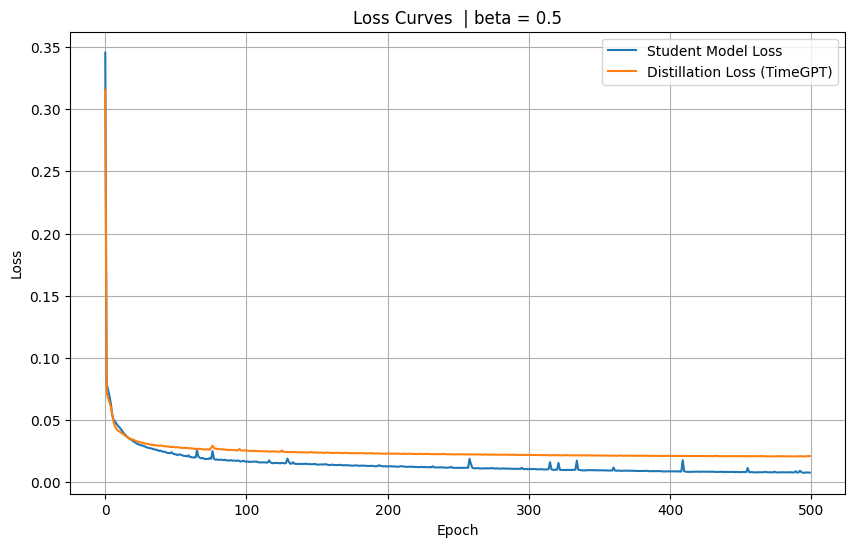

In [8]:
# Plot loss curves for teacher and student models
plt.figure(figsize=(10, 6))
#plt.plot(teacher_losses, label='Teacher Model Loss')
plt.plot(student_losses, label='Student Model Loss')
plt.plot(distil_losses, label='Distillation Loss (TimeGPT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss Curves  | beta = {beta}')
plt.legend()
plt.grid(True)
plt.show()



Plot from train evaluation

Distillation


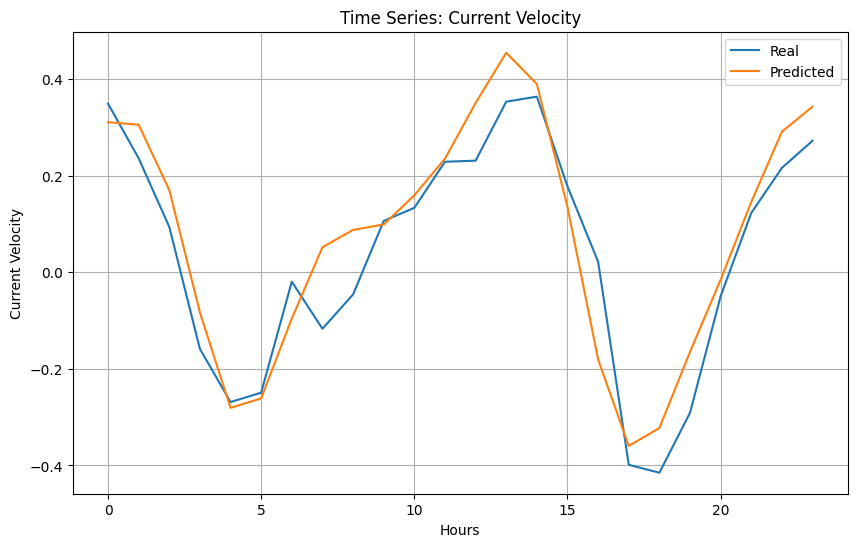


Student


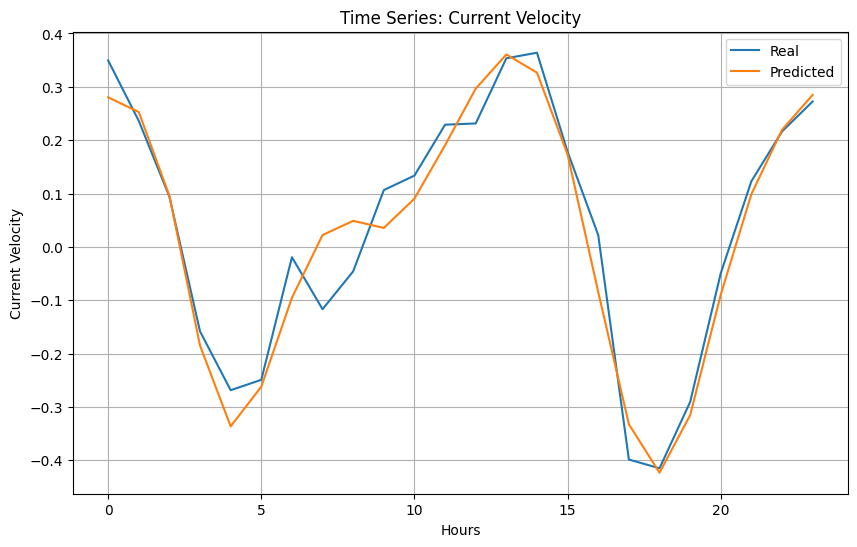

Student Model Index of Agreement (IoA): 0.9926951457311102
Distillation Student Model Index of Agreement (IoA): 0.9783542612297462


In [9]:
student_model.eval()
with torch.no_grad():
    student_train_predictions = student_model(X_train_tensor).cpu().numpy()

# Calculate IoA for teacher and student models
# ioa_train_teacher = calculate_ioa(y_train, teacher_train_predictions)
ioa_train_student = calculate_ioa(y_train, student_train_predictions)

distil_student_model.eval()
with torch.no_grad():
    distil_student_train_predictions = distil_student_model(X_train_tensor).cpu().numpy()

# Calculate IoA for teacher and student models
# ioa_train_teacher = calculate_ioa(y_train, teacher_train_predictions)
distil_ioa_train_student = calculate_ioa(y_train, distil_student_train_predictions)

print('\n\nPlot from train evaluation\n')
print('Distillation')
plot_time_series(y_train[0], distil_student_train_predictions[0])
print('\nStudent')
plot_time_series(y_train[0], student_train_predictions[0])

# print("Teacher Model Index of Agreement (IoA):", ioa_train_teacher)
print("Student Model Index of Agreement (IoA):", ioa_train_student)
print("Distillation Student Model Index of Agreement (IoA):", distil_ioa_train_student)



Plot from test evaluation

Distillation
Distillation Student Model Index of Agreement (IoA): 0.9648469844170658


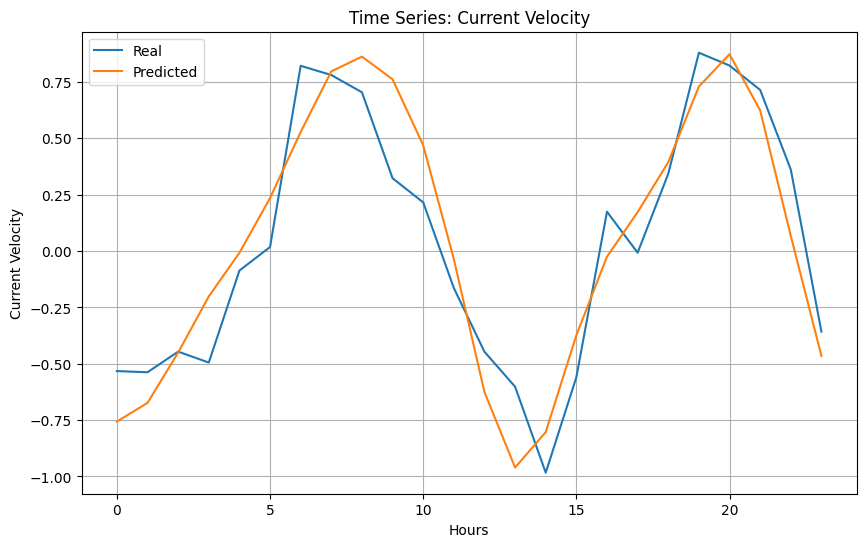


Student
Student Model Index of Agreement (IoA): 0.974184699957202


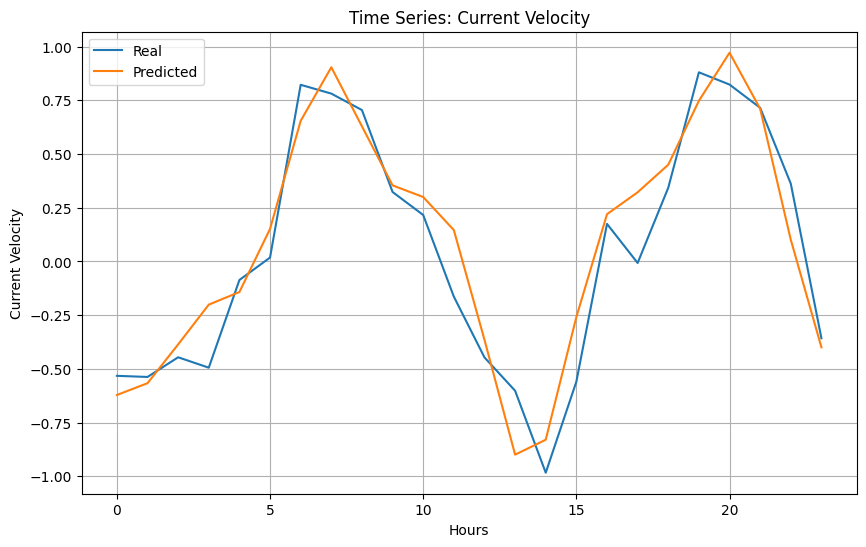

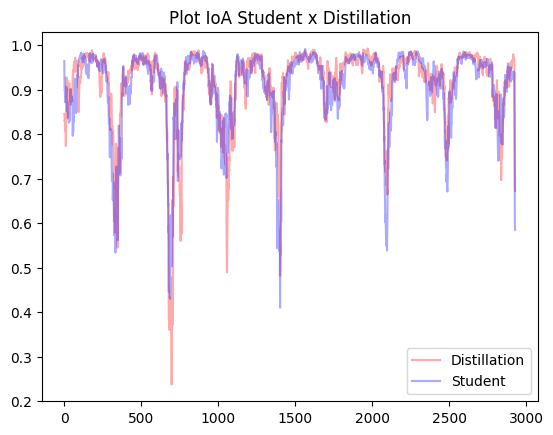

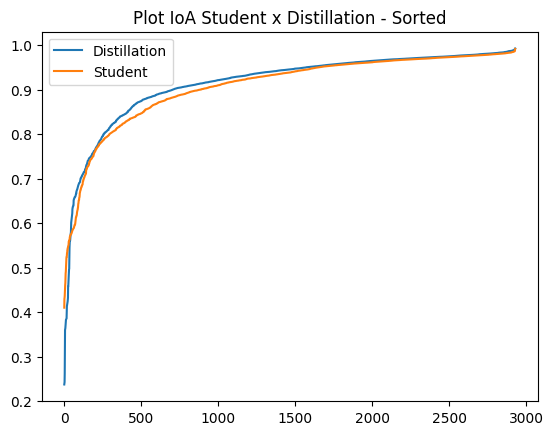

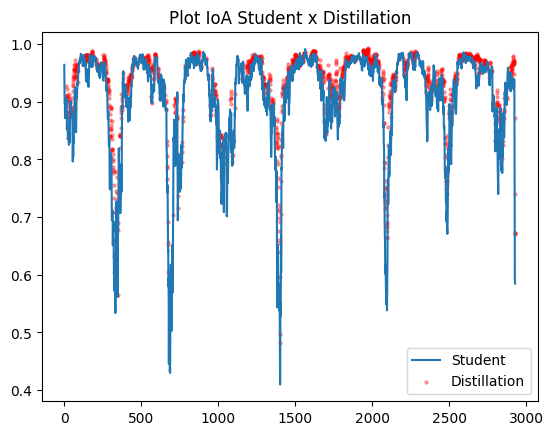

In [10]:
# Test evaluation for student model
student_model.eval()
with torch.no_grad():
    student_test_predictions = student_model(X_test_tensor).cpu().numpy()

# Calculate IoA for student model
ioa_test_student = [calculate_ioa(_y, _pred) for _y, _pred in zip(y_test, student_test_predictions)]

# Test evaluation for distilled student model
distil_student_model.eval()
with torch.no_grad():
    distil_student_test_predictions = distil_student_model(X_test_tensor).cpu().numpy()

# Calculate IoA for distilled student model
distil_ioa_test_student = [calculate_ioa(_y, _pred) for _y, _pred in zip(y_test, distil_student_test_predictions)]

# Print and plot test evaluation results
print('\n\nPlot from test evaluation\n')
print('Distillation')
print("Distillation Student Model Index of Agreement (IoA):", calculate_ioa(y_test[200], distil_student_test_predictions[200]))
plot_time_series(y_test[200], distil_student_test_predictions[200])
print('\nStudent')
print("Student Model Index of Agreement (IoA):", calculate_ioa(y_test[200], student_test_predictions[200]))
plot_time_series(y_test[200], student_test_predictions[200])

# Calculate IoA for all test data
list_ioa_test_student = [calculate_ioa(_y, _pred) for _y, _pred in zip(y_test, student_test_predictions)]
list_distil_ioa_test_student = [calculate_ioa(_y, _pred) for _y, _pred in zip(y_test, distil_student_test_predictions)]

print('\n\n')

# Plot IoA for student and distilled student models
plt.title('Plot IoA Student x Distillation')
plt.plot(list_distil_ioa_test_student, color='#FF000055', label='Distillation')
plt.plot(list_ioa_test_student, color='#0000FF55', label='Student')
plt.legend()
plt.show()

print('\n\n')

# Plot sorted IoA for student and distilled student models
plt.title('Plot IoA Student x Distillation - Sorted')
plt.plot(np.sort(list_distil_ioa_test_student), label='Distillation')
plt.plot(np.sort(list_ioa_test_student), label='Student')
plt.legend()
plt.show()

print('\n\n')

# Plot IoA and best predicted points form distillation model
list_x = [i for i, (distil_ioa, ioa) in enumerate(zip(list_distil_ioa_test_student, list_ioa_test_student)) if distil_ioa > ioa]
list_y = [distil_ioa for distil_ioa, ioa in zip(list_distil_ioa_test_student, list_ioa_test_student) if distil_ioa > ioa]

plt.title('Plot IoA Student x Distillation')
plt.plot(list_ioa_test_student, label='Student')
plt.scatter(list_x, list_y, color='#FF000055', label='Distillation', s=5)
plt.legend()
plt.show()

100%|██████████| 2928/2928 [00:00<00:00, 20326.80it/s]


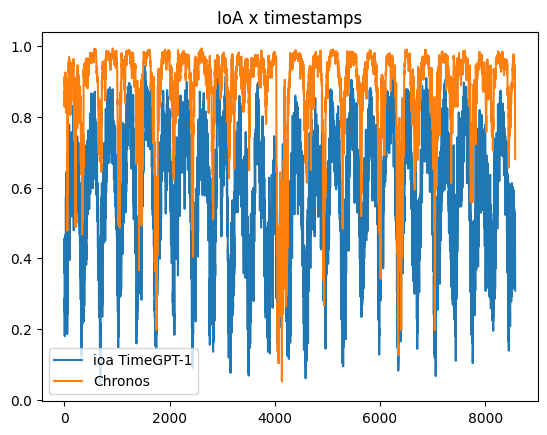

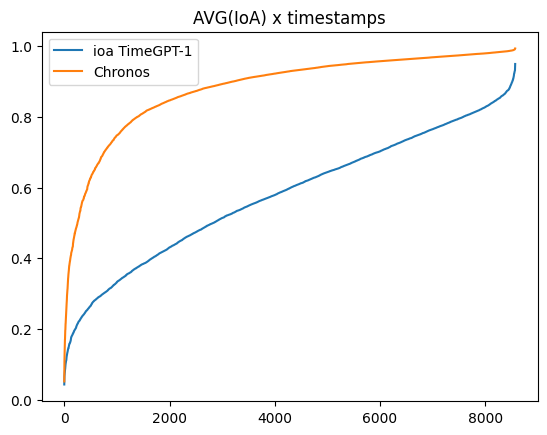

In [11]:
list_ioa_timegpt = []
list_ioa_chronos = []

list_ioa_timegpt = [calculate_ioa(y_train[i], y_train_timegpt[i]) for i in tqdm(range(len(y_train)))]
list_ioa_timegpt.extend([calculate_ioa(y_test[i], y_test_timegpt[i]) for i in tqdm(range(len(y_test)))])

list_ioa_chronos = [calculate_ioa(y_train[i], y_train_chronos[i]) for i in tqdm(range(len(y_train)))]
list_ioa_chronos.extend([calculate_ioa(y_test[i], y_test_chronos[i]) for i in tqdm(range(len(y_test)))])


plt.plot(list_ioa_timegpt,label='ioa TimeGPT-1')
plt.plot(list_ioa_chronos,label='Chronos')
plt.legend()
plt.title('IoA x timestamps')
plt.show()

plt.plot(np.sort(list_ioa_timegpt),label='ioa TimeGPT-1')
plt.plot(np.sort(list_ioa_chronos),label='Chronos')
plt.legend()
plt.title('AVG(IoA) x timestamps')
plt.show()

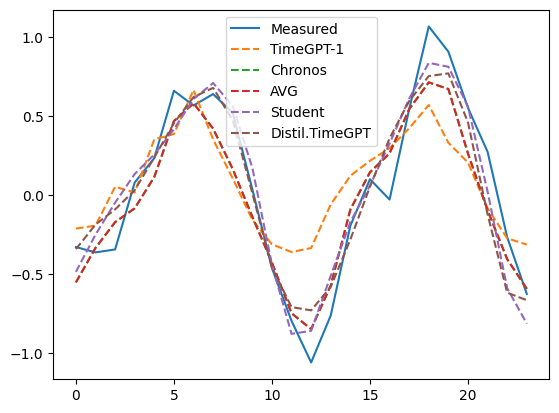

IoA TimeGPT-1:      0.8214868505361475
IoA Chronos:        0.9604589565698999
IoA AVG:            0.9604589565698999
IoA Student:        0.9743957495034614
IoA Distil.TimeGPT: 0.9668042257188967


In [12]:
idx_plot = 500

plt.plot(y_test[idx_plot],label='Measured')
plt.plot(y_test_timegpt[idx_plot],'--',label='TimeGPT-1')
plt.plot(y_test_chronos[idx_plot],'--',label='Chronos')
plt.plot(y_test_teacher[idx_plot],'--',label='AVG')
plt.plot(student_test_predictions[idx_plot],'--',label='Student')
plt.plot(distil_student_test_predictions[idx_plot],'--',label='Distil.TimeGPT')

plt.legend()
plt.show()

print(f'IoA TimeGPT-1:      {calculate_ioa(y_test[idx_plot], y_test_timegpt[idx_plot])}')
print(f'IoA Chronos:        {calculate_ioa(y_test[idx_plot], y_test_chronos[idx_plot])}')
print(f'IoA AVG:            {calculate_ioa(y_test[idx_plot], y_test_teacher[idx_plot])}')
print(f'IoA Student:        {calculate_ioa(y_test[idx_plot], student_test_predictions[idx_plot])}')
print(f'IoA Distil.TimeGPT: {calculate_ioa(y_test[idx_plot], distil_student_test_predictions[idx_plot])}')